## Udacity carnd term1
## Project5 Vehicle Detection and Tracking 


This demo shows how to approach Vehicle Tracking with deep learing.
Using the data from udacitys "Vehicle Detection and Tracking" project. 

The the the dataset this was model was trained on can be found in udacity's repo:
https://github.com/udacity/CarND-Vehicle-Detection

### Main ideas:
1) I use Keras build an neural network model to detect the vehicle.   
2) Using the trained model to convert the image to heatmap.   
3) Then using threshold in heatmap. Define interesting area.  
4) Locate the car in heatmap , I build a function named"search_active_region".  
5) Draw rectangle in image.  

## Step0 Readin data, train the classifier

#### Readin dataset,  generate X vector and Y vector.

In [1]:
import glob 
import cv2
import numpy as np
import skimage
from skimage import data, color, exposure

#The images provided (car and non car) shoulb be placed in ./vehicles/ and ./non-vehicles/
cars = glob.glob("./vehicles/*/*.png")
non_cars = glob.glob("./non-vehicles/*/*.png")

# Generate Y Vector
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])

# Read X Vector
X = []
for name in cars:    
    X.append(skimage.io.imread(name))
for name in non_cars:    
    X.append(skimage.io.imread(name))
X = np.array(X)

#### After loading I devide the data to test set and validation set


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
input_shape =  (3,64,64)

X_train shape: (15984, 64, 64, 3)
15984 train samples
1776 test samples


#### Feature extraxtion and Define Keras model 

Because I am more familiar with neural network than other models, I select Keras to build an neural network classifier.

In the model definition I do not use any dense layers, but analogous Convolution2D layers. Also, since I do not have classes, but -1 and 1, I use the mse metric for loss. 

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras.utils import np_utils
from keras import backend as K

def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    
    #conv1
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Dropout(0.25))
    
    #conv2
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    
    #dense 1
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1")) 
    model.add(Dropout(0.5))
    
    #dense 2
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh"))
    if filename:
        model.load_weights(filename)        
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='mse',optimizer='adadelta',metrics=['accuracy'])


C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (3, 3), input_shape=(64, 64, 3..., name="conv1", activation="relu", padding="same")`
C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (3, 3), activation="relu", name="conv2", padding="same")`
C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (8, 8), activation="relu", name="dense1")`
C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), activation="tanh", name="dense2")`


In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_7 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 10)        280       
_________________________________________________________________
dropout_16 (Dropout)         (None, 64, 64, 10)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 10)        910       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 10)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 8, 8, 10)          0         
_________________________________________________________________
dense1 (Conv2D)              (None, 1, 1, 128)         82048     
__________

In [19]:
model.fit(X_train, Y_train, batch_size=128, nb_epoch=20, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save_weights("model.h5")

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\keras\models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 15984 samples, validate on 1776 samples
Epoch 1/20
15984/15984 [==============================] - 36s - loss: 0.6973 - acc: 0.3544 - val_loss: 0.3974 - val_acc: 0.4668

## Step1 Turn the image into a heat map
Since the model is all Conv2d I do not actually specify image dimensions (although that is useful for training). I feed the whole image to the CNN, it output an heatmap which shows probability of vehiche.

#### Still need to improve:
The heatmap predict high possibility in the sky,traffic sign, trees. I think I can improve the model and the pipeline later.

#### Debugging solution:
When I found an error in the output vedio. I found the exact frame. And put the image path to the "imread" function. Then I can find the bug step by step.

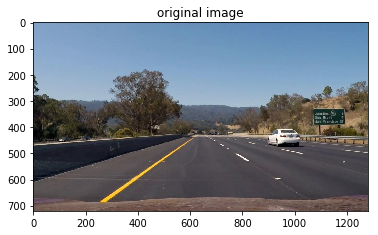

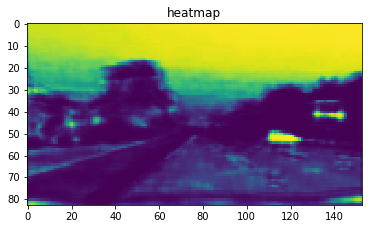

In [214]:
%matplotlib inline
import matplotlib.pylab as plt

data = (skimage.io.imread("./frame_images/image_00487.jpg"))
heatmodel = get_conv(input_shape=(None,None,3), filename="model.h5")
heatmap = heatmodel.predict(data.reshape(1,data.shape[0],data.shape[1],data.shape[2]))

plt.title("original image")    
plt.imshow(data)
plt.show()
plt.title("heatmap")    
plt.imshow(heatmap[0,:,:,0])
plt.show()

## Step2 Car area
I ignore the bottom of the image, and the top half of the image.Obviously, my classifier failed at some trees, so I ignore some left side of the image.

I use an threshold to focus on the area I interest. The `HEAR_THRESH` defined which point I accept and which point I disgard, it is a very important parameter.

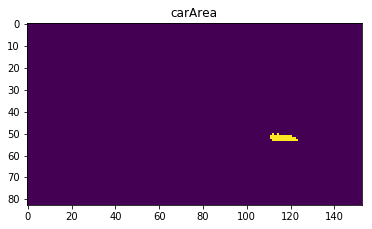

In [215]:
HEAT_THRESH = 0.8

carArea = heatmap[0,:,:,0]>HEAT_THRESH
carArea[0:45,:] = (0>1)
carArea[75:83,:] = (0>1)
carArea[:,0:70] = (0>1)

plt.title("carArea")    
plt.imshow(carArea)
plt.show()

## Step3 Another heat image, 1280x720
This heat image only include the intreseting area, and it is resized to 1280x720.

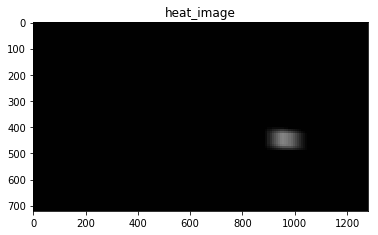

In [109]:
xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
x = (xx[carArea])
y = (yy[carArea])
heat_image = np.ones((data.shape),dtype = np.uint8);
for i,j in zip(x,y):
    heat_image[j*8:(j*8+64), i*8:(i*8+64)] += 5
heat_image = np.clip(heat_image, 0, 200)

plt.title("heat_image")    
plt.imshow(heat_image)
plt.show()

## Step4 Find window location
The basic idea is search in X first, then search in Y.

I build an histogram in X coordinate, and find the object in "histogram_X",put the value in "windowsX".Then, in finded "windowsX", calculate another histogram. If the value of histogram bigger than margin, it is an vehichle object.This function could find several objects at one time.

In [110]:
import copy

def search_active_region(image,margin=1000):
    #search in X coordinate
    histogram_x = np.sum(image, axis=0)
    windowsX = []
    for x in range(data.shape[1]-1):
        if histogram_x[x][0]<margin and histogram_x[x+1][0]>=margin:
            windowsX.append(x)
        if  histogram_x[x][0]>margin and histogram_x[x+1][0]<=margin:
            windowsX.append(x)
        if (x==0 or x==1278) and histogram_x[x][0]>=margin:
            windowsX.append(x)
            
    #searching in Y coordinate
    windows = []
    for i in range(int(len(windowsX)/2)):
        x_low = windowsX[i*2]
        x_high = windowsX[i*2+1]
        sum_in_window = np.sum(image[:,x_low:x_high,:], axis=1)
        pointsY=[]
        
        for y in range(data.shape[0]-1):
            if sum_in_window[y][0]<margin and sum_in_window[y+1][0]>=margin:
                pointsY.append(y)
            if  sum_in_window[y][0]>margin and sum_in_window[y+1][0]<=margin:
                pointsY.append(y)
            if (y==0 or x==data.shape[0]-2) and sum_in_window[y][0]>=margin:
                pointsY.append(y)
        
        if len(pointsY)> 0:
            for j in range(int(len(pointsY)/2)):
                window = [x_low,pointsY[j],x_high,pointsY[j+1]]
                windows.append(window)
    
    return windows

#draw windows on image
windows = search_active_region(heat_image,margin=1000) 
print('windows find:',windows)

windows find: [[887, 407, 1047, 487]]


## Define vedio pipeline 

The pipeline include the above steps.  
Step1 create an heatmap using neural network model.  
Step2 find car area using thrshold.  
Step3 rearange the heatmap in original size.  
Step4 find windows and draw windows on image.  
Step5 draw picture in picture and write comments.

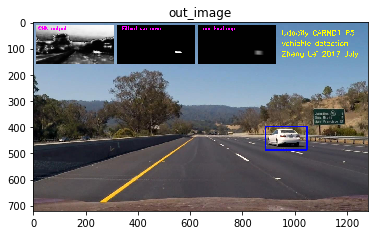

True

In [222]:
heatmodel = get_conv(input_shape=(None,None,3), filename="model.h5")

def process_image_P5(data, HEAT_THRESH = 0.75):
    
    #step1 recognize car in image
    heatmap = heatmodel.predict(data.reshape(1,data.shape[0],data.shape[1],data.shape[2]))

    #step2 car area
    carArea = heatmap[0,:,:,0]>HEAT_THRESH
    carArea[0:45,:] = (0>1)
    carArea[:,0:70] = (0>1)
    carArea[75:83,:] = (0>1)
    
    #step3 heat map 1280*720
    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[carArea])
    y = (yy[carArea])
    heat_image = np.ones((data.shape),dtype = np.uint8);
    for i,j in zip(x,y):
        heat_image[j*8:(j*8+64), i*8:(i*8+64)] += 5
    heat_image = np.clip(heat_image, 0, 200)

    #step4 draw windows on image
    windows = search_active_region(heat_image)
    
    copy_data = copy.deepcopy(data)
    for i in range(int(len(windows))):
        cv2.rectangle(copy_data, (windows[i][0],windows[i][1]-10), (windows[i][2],windows[i][3]), (0,0,255), 3)
        
    #step5 picture in picture
    heat1 = heatmap[0,:,:,0]*255 
    heat_int = heat1.astype(np.uint8)
    heatmap_RGB =  np.dstack((heat_int,heat_int,heat_int))
    heatmap_resize = cv2.resize(heatmap_RGB,None,fx=2.0,fy =2.0)
    
    carArea_RGB = np.dstack((carArea,carArea,carArea))*255
    carArea_RGB = np.uint8(carArea_RGB)
    carArea_resize = cv2.resize(carArea_RGB,None,fx=2.0,fy =2.0)
    
    heat_image_resize = cv2.resize(heat_image,None,fx=0.24,fy =0.24)
    
    copy_data[10:160, 10:310] = heatmap_resize[0:150, 0:300]
    copy_data[10:160, 320:620] = carArea_resize[0:150, 0:300]
    copy_data[10:160, 630:930] = heat_image_resize[0:150, 0:300]

    #step6 write comment in vedio
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(copy_data,'CNN output ',(20,30), font, 0.6,(255,0,255),2)
    cv2.putText(copy_data,'Filterd car area ',(340,30), font, 0.6,(255,0,255),2)
    cv2.putText(copy_data,'car heatmap ',(650,30), font, 0.6,(255,0,255),2)
    cv2.putText(copy_data,'Udacity CARND1 P5 ',(950,50), font, 0.9,(255,255,0),2)
    cv2.putText(copy_data,'vehichle detection ',(950,90), font, 0.9,(255,255,0),2)
    cv2.putText(copy_data,'Zheng Lei 2017 July ',(950,130), font, 0.9,(255,255,0),2)
    return copy_data

out_image = process_image_P5(data)
plt.title("out_image")    
plt.imshow(out_image)
plt.show()

#Save sample image
write_name = './readme_img/out_image.jpg'
cv2.imwrite(write_name,cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB))

In [211]:
from moviepy.editor import VideoFileClip
output_name = 'output_vedio/find_car_video_out.mp4'
clip1 = VideoFileClip('./project_video.mp4')
out_clip = clip1.fl_image(process_image_P5) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_name, audio=False)

[MoviePy] >>>> Building video output_vedio/find_car_video_out.mp4
[MoviePy] Writing video output_vedio/find_car_video_out.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [12:33<00:00,  5.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_vedio/find_car_video_out.mp4 

Wall time: 12min 33s
